# Demand Prediction for Dockless Vehicles using Amzon SageMaker and Amazon Athena

We demonstrate building a machine learning model for short term demand predictions of dockless vehicles in different neighborhood of Loisville, KY. The project has been inspired by several Kaagle competitions and publications.

The goal is to develop a demand model that predicts the number of vehicles needed within the next hour for each neighborhood.

The data set is provided by the Office of Advanced Planning of Loisville, Kentucky.
The data set contains trip data of individual vehicles with start and end locations. The start and end times are truncated to 15 minute intervals, though we aggregate over the full hour.


In [2]:
import boto3
import re
import s3fs
import pandas as pd

import numpy as np
import datetime


import sagemaker
ROLE = sagemaker.get_execution_role()
print(f"Role: {ROLE}")

REGION = 33.Session().region_name

S3BUCKET = f'athena-blog-1'
# S3PREFIX = 'taxi_data_raw/athena_data'
S3PREFIX = 'dockless_vehicles/ml'

DATAFILE = 'ml_train_test_data.csv'
print(DATAFILE)

def printShape(df):
    print(f"Number of records: {df.shape[0]:,}, number of columns: {df.shape[1]}")
    

Role: arn:aws:iam::969171869770:role/service-role/AmazonSageMaker-ExecutionRole-20210428T175911
ml_train_test_data.csv


In [6]:
df = pd.read_csv(DATAFILE)
df.dropna(inplace=True)
printShape(df)

Number of records: 895,413, number of columns: 17


In [7]:
df.head()

,date,nbid,hour,dow,n_start,n_end,n_start_1,n_start_2,n_start_3,n_start_4,n_end_1,n_end_2,n_end_3,n_end_4,y_start_1,y_start_2,y_start_3
4,2018-08-09,35,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2018-08-09,35,23,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2018-08-09,35,6,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2018-08-09,35,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2018-08-09,35,11,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df.columns

Index(['date', 'nbid', 'hour', 'dow', 'n_start', 'n_end', 'n_start_1',
       'n_start_2', 'n_start_3', 'n_start_4', 'n_end_1', 'n_end_2', 'n_end_3',
       'n_end_4', 'y_start_1', 'y_start_2', 'y_start_3'],
      dtype='object')

Extract all-zero rows and use a sub-sample to balanace data set

In [15]:
num_cols = ['n_start', 'n_end','n_start_1', 'n_start_2', 'n_start_3', 'n_start_4', 'n_end_1', 'n_end_2', 'n_end_3', 'n_end_4', 'y_start_1', 'y_start_2', 'y_start_3']
mask = df[num_cols].values.sum(axis=1)>0
mask.shape, mask.sum()

df_zero = df[~mask].sample(10000)
printShape(df_zero)
df_nonzero = df[mask]
printShape(df_nonzero)
df2 = pd.concat([df_zero, df_nonzero])
printShape(df2)

Number of records: 10,000, number of columns: 17
Number of records: 304,619, number of columns: 17
Number of records: 314,619, number of columns: 17


# Processing Data

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.exceptions import DataConversionWarning

In [16]:
features = ['y_start_1', 'nbid', 'hour', 'dow', 'n_start_1', 'n_start_2', 'n_start_3', 'n_start_4',
             'n_end_1', 'n_end_2', 'n_end_3', 'n_end_4' ]
display(df2[features].tail())
    
### Save the data to S3 bucket
input_data = df2[features].dropna().copy()
print(f"Number of rows: {input_data.shape[0]:,}")

dataInPath = f's3://{S3BUCKET}/{S3PREFIX}/data/data_in.csv'
input_data.to_csv(dataInPath, sep = ',', index = False)

,y_start_1,nbid,hour,dow,n_start_1,n_start_2,n_start_3,n_start_4,n_end_1,n_end_2,n_end_3,n_end_4
895367,0.0,9,17,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
895368,0.0,9,11,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
895369,0.0,9,9,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
895370,0.0,9,18,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
895371,0.0,9,5,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Number of rows: 314,619


In [17]:
### Import required libraries
 
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor 
 
### Create an scikit-learn processor
 
sklearn_processor = SKLearnProcessor(
    framework_version = '0.20.0',       # specify the scikit-learn version that we want to use - the image will be this version
    role              = ROLE,           # insert the role
    instance_type     = 'ml.m5.xlarge', # this is the "normal" instance type
    instance_count    = 1,              # we only use 1 instance
    base_job_name     = f'dockless-processing', # need to follow ADA Datalab guideline     
)

## Process script

In [18]:
%%writefile preprocessing.py
 
import argparse
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
 
def print_shape(df):
    pass
 
if __name__=='__main__':
 
    ### Specifying input path - Note how set the input paths
 
    input_data_path = os.path.join('/opt/ml/processing/input', 'data_in.csv')
     
    ### Reading + basic data handling
 
    print('Reading input data from {}'.format(input_data_path))
    data_raw = pd.read_csv(input_data_path) #### , parse_dates=['t_hour'])
#     features = ['y_start_1', 'location_id', 'hr', 'dayofweek', 'n_start_1', 'n_start_2', 'n_start_3', 'n_start_4',
#              'n_end_1', 'n_end_2', 'n_end_3', 'n_end_4' ]
    features = list(data_raw.columns)
    label_col = features[0]
    data = data_raw[features]
    # data = pd.DataFrame(data = data)
     
    ### Transform response variable
 
    
     
    ### data split in three sets, training, validation and batch inference
 
    rand_split = np.random.rand(len(data))
    train_list = rand_split < 0.8
    val_list   = (rand_split >= 0.8) & (rand_split < 0.9)
    test_list  = rand_split >= 0.9
 
    ### Split data to train, validation and test
 
    data_train = data[train_list]
    data_val   = data[val_list]
    data_test  = data[test_list]
    test_class = data_test[label_col]
    data_test  = data_test.drop([label_col], axis = 1)
 
    ### Specifying output paths - Note how set the output paths
 
    train_features_output_path      = os.path.join('/opt/ml/processing/train',      'train_data.csv')
    validation_features_output_path = os.path.join('/opt/ml/processing/validation', 'validation_data.csv')
    test_features_output_path       = os.path.join('/opt/ml/processing/test',       'test_data.csv')
    test_classes_output_path        = os.path.join('/opt/ml/processing/test',       'test_class.csv')
     
    ### Save files to output destinations
 
    pd.DataFrame(data_train).to_csv(train_features_output_path,    header = False, index = False)
    pd.DataFrame(data_val).to_csv(validation_features_output_path, header = False, index = False)
    pd.DataFrame(data_test).to_csv(test_features_output_path,      header = False, index = False)
    pd.DataFrame(test_class).to_csv(test_classes_output_path,      header = False, index = False)

Overwriting preprocessing.py


## Upload and Run

In [20]:
### Copy the preprocessing code over to the s3 bucket
 
sess       = sagemaker.Session()
codeprefix = S3PREFIX + '/scripts'
codeupload = sess.upload_data('preprocessing.py', bucket = S3BUCKET, key_prefix = codeprefix)
print(codeupload)
 
### Import ProcessingInput and ProcessingOutput function
from sagemaker.processing import ProcessingInput, ProcessingOutput
 
### Set our data destination path in S3
dataDestination = 's3://' + S3BUCKET + '/' + S3PREFIX
 
### Run the processing job
sklearn_processor.run(
    code    = codeupload,
    inputs  = [ProcessingInput(source = dataInPath, destination = '/opt/ml/processing/input')],
    outputs = [
        ProcessingOutput(
            output_name = 'train_data',
            source      = '/opt/ml/processing/train',
            destination = dataDestination + '/train/'
        ),
        ProcessingOutput(
            output_name = 'validation_data', 
            source      = '/opt/ml/processing/validation',
            destination = dataDestination + '/validation/'
        ),
        ProcessingOutput(
            output_name = 'test_data',
            source      = '/opt/ml/processing/test',
            destination = dataDestination + '/test/'
        )
    ]
)

s3://athena-blog-1/dockless_vehicles/ml/scripts/preprocessing.py

Job Name:  dockless-processing-2021-05-13-09-31-44-921
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://athena-blog-1/dockless_vehicles/ml/data/data_in.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://athena-blog-1/dockless_vehicles/ml/scripts/preprocessing.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'train_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://athena-blog-1/dockless_vehicles/ml/train/', 'LocalPath': '/opt/ml/processing/train', 'S3UploadMode': 'EndOfJob'}}, {'OutputName': 'validation_data', 'AppManaged': False, 'S3Output': {'

# Training Data

In [22]:
### This is to get the image df_nonzerohe XGBoost
 
from sagemaker.amazon.amazon_estimator import get_image_uri

image = get_image_uri(REGION, 'xgboost', '1.2-1')
#image = sagemaker.image_uris.retrieve("xgboost", REGION, "1.2-1")
print(f"Using ML image '{image}' in region '{REGION}'")
 
### This is the output location of the model
 
output_location = 's3://{}/{}'.format(S3BUCKET, S3PREFIX)
print('training artifacts will be uploaded to: {}'.format(output_location))
 
### Training Parameters
import datetime
ts = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
job_name = f"dockless-training-{ts}"

create_training_params = {
    "AlgorithmSpecification": {
        "TrainingImage": image,     ### This is the image of the XGBoost that we want to use as built-in algorithm directly
        "TrainingInputMode": "File"
    },
    "RoleArn": ROLE, 
    "OutputDataConfig": {
        "S3OutputPath": output_location ### This is the output location (with some addition on prefix, etc) where model.tar.gz will be stored
    },
    "ResourceConfig": {
        "InstanceCount": 1, 
        "InstanceType": "ml.m5.4xlarge",
        "VolumeSizeInGB": 50,
    },
    "TrainingJobName": job_name, ### This is the training job name that we have provided previously
    "HyperParameters": {
        ## "objective": "binary:logistic", ### For our case, we use binary:logistic as our objective function (0/1 case)
        "objective": "reg:squarederror", ### For our case, we use binary:logistic as our objective function (0/1 case)
        "max_depth": "5",
        "eta": "0.2",
        "gamma": "4",
        "min_child_weight": "6",
        "subsample": "0.8",
        # "silent": "0",
        "num_round": "500"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 60
    },
    "InputDataConfig": [
        {
            "ChannelName": "train", ### This contains the channels that we want to use for training, here we are using train and validation channel
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/{}/train'.format(S3BUCKET, S3PREFIX),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
            "ContentType": "text/csv"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/{}/validation'.format(S3BUCKET, S3PREFIX),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
            "ContentType": "text/csv"
        }
    ],
}
 
sagemaker = boto3.client('sagemaker')
 
### Create Training Job
 
sagemaker.create_training_job(**create_training_params)
 
### Describe the status of training job
 
status = sagemaker.describe_training_job(TrainingJobName = job_name)['TrainingJobStatus']
print(status)
 
try:
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName = job_name)
finally:
    status = sagemaker.describe_training_job(TrainingJobName = job_name)['TrainingJobStatus']
    print("Training job ended with status: " + status)
    if status == 'Failed':
        message = sagemaker.describe_training_job(TrainingJobName = job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Training job failed')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Using ML image '257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.2-1' in region 'us-east-2'
training artifacts will be uploaded to: s3://athena-blog-1/dockless_vehicles/ml
InProgress
Training job ended with status: Completed


# Create Model

In [26]:
sagemaker = boto3.client('sagemaker')
info = sagemaker.describe_training_job(TrainingJobName = job_name) # This is to see all the details of your training job
model_data = info['ModelArtifacts']['S3ModelArtifacts'] # That detail includes where the model.tar.gz is saved in your S3 bucket
 
print(f"""
Model Info
----------
Location of model parameters: {model_data}
Container image:              {image}
Training job:                 {job_name}

""")

primary_container = {
    'Image': image,            # This is the image for inference (not for training). But in our case, this is the same as training image.
    'ModelDataUrl': model_data # This is the model artifacts, the one with model.tar.gz
}
 
create_model_response = sagemaker.create_model(
    ModelName = f'dockless-regression-model',    # Specify the job name of the training job earlier on
    ExecutionRoleArn = ROLE, # Specify the role, which equals to get_execution_role()
    PrimaryContainer = primary_container, # Specify the primary container. 
)
 
print(create_model_response['ModelArn'])


Model Info
----------
Location of model parameters: s3://athena-blog-1/dockless_vehicles/ml/dockless-training-20210513-093745/output/model.tar.gz
Container image:              257758044811.dkr.ecr.us-east-2.amazonaws.com/sagemaker-xgboost:1.2-1
Training job:                 dockless-training-20210513-093745


arn:aws:sagemaker:us-east-2:969171869770:model/dockless-regression-model


# Eval

In [27]:
import boto3
sagemaker_runtime = boto3.client('sagemaker-runtime')

In [29]:
features = ['y_start_1', 'nbid', 'hour', 'dow', 'n_start_1', 'n_start_2', 'n_start_3', 'n_start_4',
             'n_end_1', 'n_end_2', 'n_end_3', 'n_end_4' ]
df_nonzero[features].dropna().head()

,y_start_1,nbid,hour,dow,n_start_1,n_start_2,n_start_3,n_start_4,n_end_1,n_end_2,n_end_3,n_end_4
470,0.0,35,16,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
471,0.0,35,11,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
472,0.0,35,9,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
473,0.0,35,7,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
474,0.0,35,20,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [30]:

for i, r in df_nonzero[features].dropna().sample(20).iterrows():
    b = ','.join([ str(r[c]) for c in features[1:] ])
    y = r['y_start_1']
    res = sagemaker_runtime.invoke_endpoint(
        EndpointName='dockless-regression-ep',
        Body = b, ###. '79.0,2.0,3.0,727.0,721.0,1.0,3.0,602.0,421.0,1.0,1.0',
        ContentType = 'text/csv'
    )
    y_hat = float(res['Body'].read())
    print(f"{i}\ty={y}\ty_hat={y_hat}\t{b}")

114599	y=0.0	y_hat=0.03657257556915283	23.0,14.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
577313	y=0.0	y_hat=0.6612421274185181	20.0,22.0,0.0,4.0,1.0,6.0,0.0,1.0,1.0,6.0,0.0
763932	y=0.0	y_hat=-0.006854534149169922	49.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
395856	y=10.0	y_hat=0.4053572416305542	47.0,6.0,1.0,5.0,1.0,5.0,0.0,3.0,0.0,9.0,0.0
147445	y=0.0	y_hat=0.0036890506744384766	3.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196262	y=0.0	y_hat=0.022508323192596436	39.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
419153	y=0.0	y_hat=0.0021598339080810547	19.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
876123	y=0.0	y_hat=0.05208203196525574	72.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
801412	y=0.0	y_hat=0.05565375089645386	70.0,5.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
327177	y=0.0	y_hat=0.024671852588653564	63.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42257	y=1.0	y_hat=1.0007874965667725	22.0,11.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,5.0
802636	y=1.0	y_hat=0.6643890738487244	70.0,15.0,5.0,1.0,7.0,1.0,0.

In [113]:
df_nonzero.shape

(16928, 18)

In [33]:
def predict_row(r):
    features = ['y_start_1', 'nbid', 'hour', 'dow', 'n_start_1', 'n_start_2', 'n_start_3', 'n_start_4',
             'n_end_1', 'n_end_2', 'n_end_3', 'n_end_4' ] 
    
    b = ','.join([ str(r[c]) for c in features[1:] ])
    y = r['y_start_1']
    res = sagemaker_runtime.invoke_endpoint(
        EndpointName='dockless-regression-ep',
        Body = b, ###. '79.0,2.0,3.0,727.0,721.0,1.0,3.0,602.0,421.0,1.0,1.0',
        ContentType = 'text/csv'
    )
    y_hat = float(res['Body'].read())
    return y_hat
    

In [66]:
%%time
df_hat = df_nonzero.sample(10000).copy()
df_hat['y_hat'] = df_hat.apply(predict_row, axis=1)
df_hat['y_predict'] = df_hat.y_hat.round()
df_hat.rename({'y_start_1': 'y_actual'}, axis=1, inplace=True)
printShape(df_hat)


confusion_matrix = pd.pivot_table(df_hat, index='y_actual', columns='y_predict', values='date', aggfunc='count', fill_value=0)
printShape(confusion_matrix)

In [72]:
def plot_confusion_matrix(subdf, label=''):
    confusion_matrix = pd.pivot_table(subdf, index='y_actual', columns='y_predict', values='date', aggfunc='count', fill_value=0)
    print(f"Confusion Matrix: {label}")
    printShape(confusion_matrix)
    mae = np.abs(df_hat.y_actual-df_hat.y_predict).mean()
    print(f"MAE: {mae}")
    plt.figure(figsize=(12,12))
    plt.imshow(np.log1p(confusion_matrix))
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predict')
    plt.show()
    plt.close()
    return confusion_matrix

Confusion Matrix: 
Number of records: 80, number of columns: 73
MAE: 1.0903


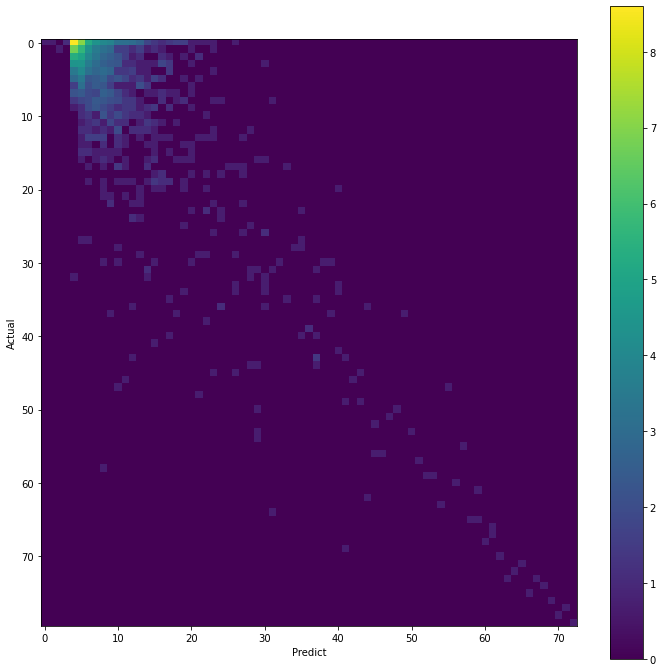

''

In [74]:
plot_confusion_matrix(df_hat)
;


Confusion Matrix: 
Number of records: 71, number of columns: 70
MAE: 1.0903


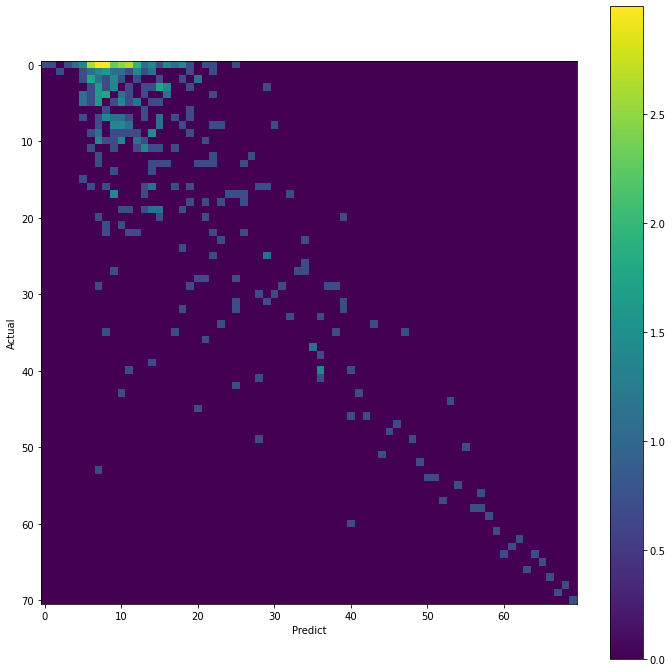

''

In [79]:
plot_confusion_matrix(df_hat[df_hat.nbid==17])
;



former value: 0.19214895122203912